In [726]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as OHE, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report

# Imbalanced modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# TensorFlow & Keras modules
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dense, Embedding, Dropout, Bidirectional)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# I am using the cleaned dataset which I created in the previous notebook
df = pd.read_csv('Datasets/Cleaned_Tweets.csv')
df.head()

,airline_sentiment,text
0,neutral,what said
1,positive,plus you've added commercials to the experien...
2,neutral,i didn't today must mean i need to take anoth...
3,negative,it's really aggressive to blast obnoxious ent...
4,negative,and it's a really big bad thing about it


In [728]:
df.head()

,airline_sentiment,text
0,neutral,what said
1,positive,plus you've added commercials to the experien...
2,neutral,i didn't today must mean i need to take anoth...
3,negative,it's really aggressive to blast obnoxious ent...
4,negative,and it's a really big bad thing about it


In [729]:
df.shape

(14640, 2)

In [730]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

## PreProcessing 

In [731]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['text'])

In [732]:
# Padding sequences to make them of equal length
MAX_LEN = 34
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN ,truncating='post')

In [733]:
X = padded_sequences
y = df['airline_sentiment']

In [734]:
y.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [735]:
# encoding the target variable and converting it to numpy array
le = LabelEncoder()
y = le.fit_transform(y)

y = to_categorical(y, num_classes=3)

In [736]:
y

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], shape=(14640, 3))

In [737]:
# Splitting the data into training and testing sets
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

In [738]:
# Save the categories into a list 
categories = list(np.unique(df['airline_sentiment']))       
categories

['negative', 'neutral', 'positive']

In [739]:
y.shape 

(27534, 3)

In [740]:
X.shape

(27534, 34)

In [741]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [742]:
print(X_train.shape, X_test.shape)  

(22027, 34) (5507, 34)


In [743]:
print(y_train.shape, y_test.shape)  

(22027, 3) (5507, 3)


## Model Structure

In [744]:
# Model parameters 
EMBEDDING_DIM = 128
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [745]:
# Building the model
model = Sequential([
    # Embedding layer to convert the text into vectors
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_shape=(MAX_LEN,)),
    # Bidirectional LSTM layer
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    # Batch Normalization layer for normalizing the model
    tf.keras.layers.BatchNormalization(),
    # Bidirectional LSTM layer
    Bidirectional(LSTM(32, dropout=0.4, recurrent_dropout=0.4)),
    tf.keras.layers.BatchNormalization(),
    # Dense layer
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

c:\Users\murta\Desktop\Desktop\ML&DE\Fourth_Semester\Advanced_ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_42 (Embedding)        │ (None, 34, 128)        │     1,863,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_46                │ (None, 34, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 34, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,004,035 (7.64 MB)

 Trainable params: 2,003,651 (7.64 MB)

 Non-trainable params: 384 (1.50 KB)

In [746]:
# Define callbacks: Early stopping and learning rate reducer
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1, mode='max')
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2 , patience=2, verbose=1)

history = model.fit(X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, lr_reducer]
)

Epoch 1/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 75s 117ms/step - accuracy: 0.4874 - loss: 1.1558 - val_accuracy: 0.7935 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 2/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 58s 106ms/step - accuracy: 0.8212 - loss: 0.4692 - val_accuracy: 0.8645 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 3/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.8947 - loss: 0.2965 - val_accuracy: 0.8842 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 4/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy: 0.9239 - loss: 0.2231 - val_accuracy: 0.8972 - val_loss: 0.3154 - learning_rate: 0.0010
Epoch 5/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy: 0.9436 - loss: 0.1706 - val_accuracy: 0.8999 - val_loss: 0.3301 - learning_rate: 0.0010
Epoch 6/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 57s 103ms/step - accuracy: 0.9486 - loss: 0.1515 - val_accuracy: 0.9042 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 7/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 57s 103ms/step - accuracy: 0.9

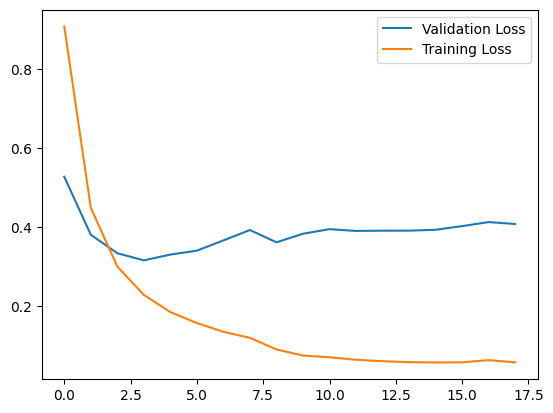

In [747]:
# Visualizing the model performance
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()

In [748]:
# predicting the test data
y_pred = model.predict(X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step


In [749]:
# Converting the predicted values to the classes
y_pred = np.argmax(y_pred, axis=1)

In [750]:
# classification report and adding categories as labels
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=categories))


              precision    recall  f1-score   support

    negative       0.94      0.84      0.89      1895
     neutral       0.87      0.92      0.89      1786
    positive       0.92      0.97      0.94      1826

    accuracy                           0.91      5507
   macro avg       0.91      0.91      0.91      5507
weighted avg       0.91      0.91      0.91      5507

